# Data Exploration

**Jakob Balkovec**
Date: Oct 30th 2025

This notebook explores the newly constructed dataset (`master.csv`) to get more insights into the data and the relationship between features.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr, pearsonr, shapiro
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests
import statsmodels.api as sm

pd.set_option("display.max_columns", 200)

In [82]:
CSV = Path(r'/Users/jbalkovec/Desktop/MDR/Temporal/Pipeline/data/master/final_master.csv')
df = pd.read_csv(CSV)

---
## Data Health and Typing

### Missing Values

In [83]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = [c for c in df.columns if c not in numeric_cols]

missing_pct = df.isna().mean().sort_values(ascending=False)
print(missing_pct.head(20))

SM_label               1.000000
soil_temp_50cm         0.504705
soil_temp_20cm         0.504411
soil_temp_100cm        0.503774
soil_moisture_100cm    0.412067
soil_moisture_50cm     0.412067
soil_moisture_20cm     0.412067
soil_temp_10cm         0.257181
soil_temp_5cm          0.256887
SM_prev                0.245221
soil_moisture_10cm     0.245074
soil_moisture_5cm      0.245074
rh_max                 0.243457
rh_min                 0.243457
rh_mean                0.236300
air_temp_avg           0.014410
air_temp_max           0.012597
air_temp_min           0.012009
precipitation          0.007793
sur_temp_min           0.007254
dtype: float64


### Coverage

In [84]:
coverage = df.groupby("station_id")["date"].agg(["min", "max", "nunique"]).sort_values("min")
display(coverage.head(10))

,min,max,nunique
station_id,,,
4223,2007-01-01,2025-10-23,6871
4237,2007-01-01,2025-10-23,6871
4136,2007-07-31,2025-10-23,6660


### Dupes

In [85]:
dupes = df.duplicated(subset=["station_id", "date"]).sum()
print("Duplicate station_id+date rows:", dupes)

Duplicate station_id+date rows: 0


---
## Summary Statistics

In [86]:
summary = df[numeric_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
summary["missing_pct"] = df[numeric_cols].isna().mean()
summary["n_unique"]   = df[numeric_cols].nunique()
summary

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,missing_pct,n_unique
station_id,20402.0,4199.314773,44.451429,4136.000000,4136.000000,4136.000000,4136.000000,4223.000000,4237.000000,4237.000000,4237.000000,4237.000000,0.000000,3
crx_vn,20402.0,2.238869,0.787300,-9.000000,1.301000,1.302000,2.402000,2.422000,2.622000,2.623000,2.623000,2.623000,0.000000,13
longitude,20402.0,-120.965163,2.580151,-123.810000,-123.810000,-123.810000,-123.810000,-121.450000,-117.530000,-117.530000,-117.530000,-117.530000,0.000000,3
latitude,20402.0,47.827505,0.509056,47.420000,47.420000,47.420000,47.420000,47.510000,48.540000,48.540000,48.540000,48.540000,0.000000,3
air_temp_max,20145.0,14.934435,9.143370,-16.600000,-3.500000,1.400000,7.800000,13.900000,22.000000,30.500000,34.700000,42.400000,0.012597,508
air_temp_min,20157.0,3.500064,6.142418,-32.600000,-14.400000,-6.900000,-0.300000,3.800000,8.100000,12.500000,14.644000,19.100000,0.012009,417
air_temp_mean,20401.0,9.240069,7.071791,-25.745134,-8.100000,-1.900000,4.200000,9.100000,14.900000,20.200000,23.000000,30.300000,0.000049,697
air_temp_avg,20108.0,8.960339,6.960261,-22.600000,-7.500000,-1.765000,3.800000,8.700000,14.500000,19.900000,23.000000,30.200000,0.014410,435
precipitation,20243.0,5.913002,14.727061,0.000000,0.000000,0.000000,0.000000,0.000000,4.600000,32.700000,69.474000,235.400000,0.007793,799
solar_radiation,20401.0,11.560944,9.297579,-20.481429,0.070000,0.640000,3.470000,9.470000,18.610000,27.430000,32.310000,114.319656,0.000049,3573


### Station Level

In [87]:
station_stats = df.groupby("station_id")[["air_temp_mean","precipitation","NDVI","LST",
                                          "soil_moisture_10cm","soil_temp_10cm"]].agg(["mean","std","min","max","median"])
station_stats.head(10)

air_temp_mean                                   precipitation  \
                    mean       std        min   max median          mean   
station_id                                                                 
4136            7.375954  8.346016 -25.745134  28.2    7.2      1.264803   
4223           10.025086  6.578159 -13.100000  28.4    9.6      5.699590   
4237           10.261650  5.717956  -5.500000  30.3    9.9     10.683904   

                                              NDVI                      \
                  std  min    max median      mean       std       min   
station_id                                                               
4136         3.272197  0.0   38.0    0.0  0.433758  0.118023  0.040046   
4223        11.360698  0.0  135.4    0.3  0.744890  0.130592  0.291836   
4237        21.532642  0.0  235.4    0.5  0.712321  0.107359  0.318498   

                                       LST                                     \
                 max    median        mean        std         min         max   
station_id                                                                      
4136        0.624729  0.451759  289.381878  13.765826  263.120717  313.908222   
4223        0.890417  0.782172  285.935077   8.619238  265.883202  299.915973   
4237        0.856568  0.718435  285.888766   7.486844  271.057854  298.428487   

                       soil_moisture_10cm                                \
                median               mean       std       min       max   
station_id                                                                
4136        290.248893           0.186285  0.158631 -1.084310  0.984601   
4223        286.679144           0.256972  0.115783 -0.305643  0.624596   
4237        286.169535           0.136701  0.055205  0.013000  0.342808   

                  soil_temp_10cm                              
           median           mean       std  min   max median  
station_id                                                    
4136        0.204       9.883998  8.042649 -4.7  26.7    8.7  
4223        0.299      10.089284  6.418051 -0.2  22.6   10.1  
4237        0.149      11.431102  5.980328 -0.5  24.4   11.2

| ID   | Location   |
|------|------------|
| 4136 | Spokane    |
| 4223 | Darrington |
| 4237 | Quinalt    |

---
## Missingness structure

### Column

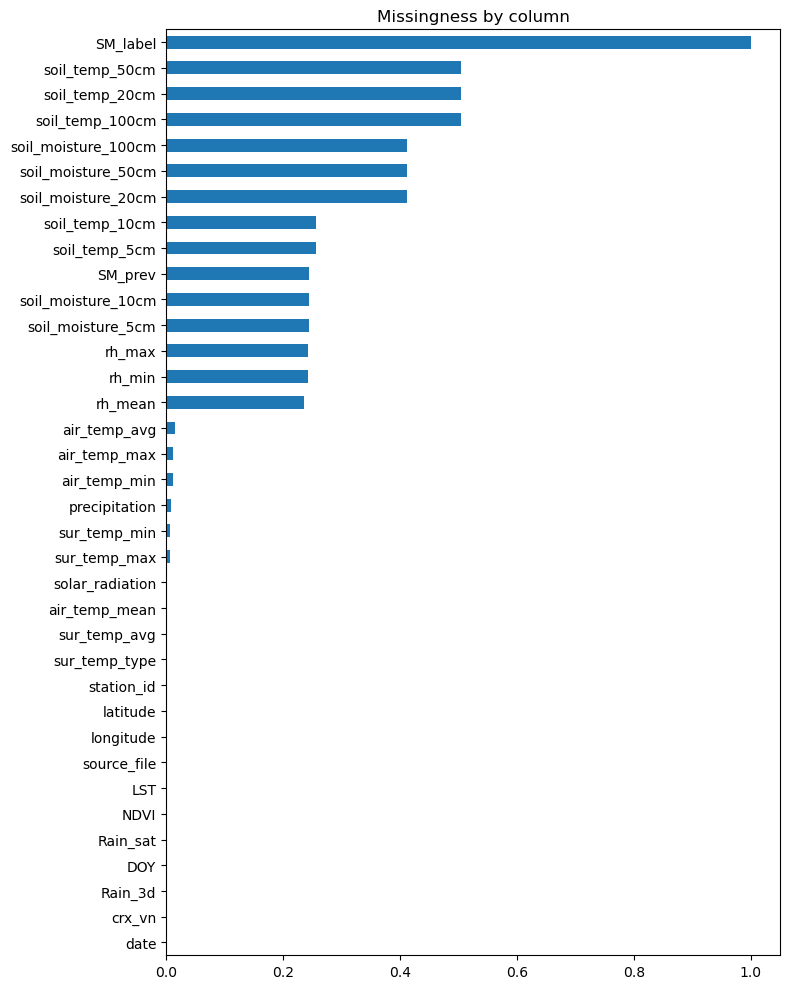

In [88]:
ax = missing_pct.plot(kind="barh", figsize=(8,10), title="Missingness by column")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Month

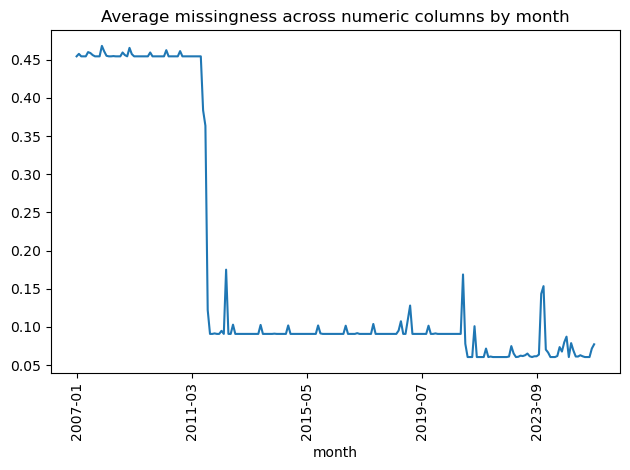

In [89]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month"] = df["date"].dt.to_period("M").astype(str)
miss_by_month = df.groupby("month")[numeric_cols].apply(lambda x: x.isna().mean().mean())
miss_by_month.plot(title="Average missingness across numeric columns by month", rot=90)
plt.tight_layout(); plt.show()

### Station

In [90]:
miss_by_station = df.groupby("station_id")[numeric_cols].apply(lambda x: x.isna().mean().mean()).sort_values(ascending=False)
miss_by_station.head(20)

station_id
4237    0.254561
4223    0.139978
4136    0.129812
dtype: float64

In [93]:
num_df = df[numeric_cols].copy()
num_df = df[numeric_cols].drop(columns=["SM_label"])

imp = SimpleImputer(strategy="median")
num_imputed = pd.DataFrame(imp.fit_transform(num_df), columns=num_df.columns, index=num_df.index)

---
## Distributions and outliers

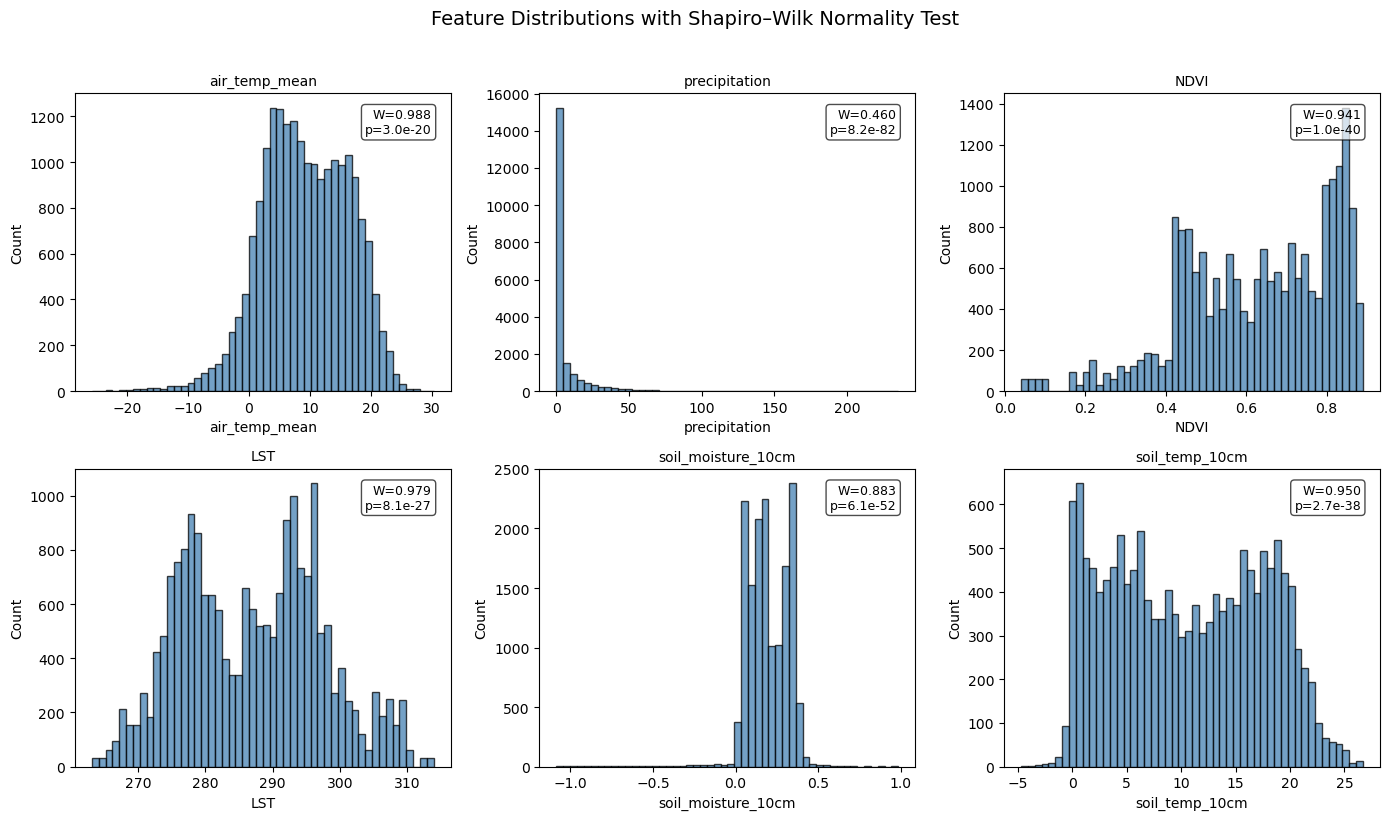

In [ ]:
to_plot = ["air_temp_mean", "precipitation", "NDVI", "LST", "soil_moisture_10cm", "soil_temp_10cm"]

n = len(to_plot)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(to_plot):
    if col in df.columns:
        s = df[col].dropna()

        axes[i].hist(s, bins=50, color="steelblue", alpha=0.75, edgecolor="black")
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")

        sample = s.sample(min(5000, len(s)), random_state=42)
        W, p = shapiro(sample)

        axes[i].text(
            0.95, 0.95,
            f"W={W:.3f}\np={p:.1e}",
            transform=axes[i].transAxes,
            ha="right", va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
        )

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Feature Distributions with Shapiro-Wilk Normality Test", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [95]:
z = np.abs(stats.zscore(num_imputed[to_plot], nan_policy='omit'))
outlier_mask = (z > 4).any(axis=1)
print("Rows with extreme outliers (|z|>4):", outlier_mask.sum())

Rows with extreme outliers (|z|>4): 338


---
## Relationships among variables

### Pairwise Correlations

In [96]:
spearman_corr = df[numeric_cols].corr(method="spearman")
pearson_corr  = df[numeric_cols].corr(method="pearson")

pairs = [("LST","soil_temp_10cm"),
         ("NDVI","soil_moisture_10cm"),
         ("air_temp_mean","LST"),
         ("precipitation","Rain_sat"),
         ("DOY","NDVI")]

# FMT BETTER
for x,y in pairs:
    if x in df and y in df:
        s = spearmanr(df[x], df[y], nan_policy="omit")
        p = pearsonr(df[[x,y]].dropna()[x], df[[x,y]].dropna()[y])
        print(f"Spearman rho={s.correlation:.3f},  Pearson r={p.statistic:.3f} | {x} vs {y}")

Spearman rho=0.905,  Pearson r=0.902 | LST vs soil_temp_10cm
Spearman rho=-0.169,  Pearson r=-0.076 | NDVI vs soil_moisture_10cm
Spearman rho=0.836,  Pearson r=0.813 | air_temp_mean vs LST
Spearman rho=0.466,  Pearson r=0.424 | precipitation vs Rain_sat
Spearman rho=0.082,  Pearson r=0.094 | DOY vs NDVI


### Partial correlation

In [97]:
def partial_corr(x, y, z):
    df_temp = pd.concat([x, y, z], axis=1).dropna()
    df_temp = df_temp.replace([np.inf, -np.inf], np.nan).dropna()

    x_clean = df_temp.iloc[:, 0]
    y_clean = df_temp.iloc[:, 1]
    z_clean = df_temp.iloc[:, 2]

    X = sm.add_constant(z_clean)

    x_resid = sm.OLS(x_clean, X).fit().resid
    y_resid = sm.OLS(y_clean, X).fit().resid

    return np.corrcoef(x_resid, y_resid)[0, 1]

if set(["LST","soil_temp_10cm","air_temp_mean"]).issubset(df.columns):
    r_pc = partial_corr(df["LST"], df["soil_temp_10cm"], df["air_temp_mean"])
    print("Partial corr(LST, soil_temp_10cm | air_temp_mean) =", round(r_pc,3))

Partial corr(LST, soil_temp_10cm | air_temp_mean) = 0.667


### Mutual Information with Target Moisture

In [98]:
target = "soil_moisture_5cm"
candidates = [c for c in numeric_cols if c not in ["SM_label","SM_prev"] and c != target]
tmp = df[[target]+candidates].dropna()
X = tmp[candidates].values
y = tmp[target].values
mi = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi, index=candidates).sort_values(ascending=False)
print(mi_series.head(15))

soil_moisture_10cm     1.377020
soil_moisture_20cm     1.196677
soil_moisture_50cm     1.071256
soil_moisture_100cm    1.034546
LST                    0.975481
NDVI                   0.869984
Rain_sat               0.822915
DOY                    0.712436
soil_temp_100cm        0.669966
soil_temp_50cm         0.653823
soil_temp_20cm         0.621326
soil_temp_10cm         0.588288
soil_temp_5cm          0.541468
air_temp_max           0.401960
sur_temp_avg           0.399798
dtype: float64


### Multicollinearity check (VIF)

In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_cols = [c for c in candidates if df[c].notna().mean() > 0.95 and c not in ["station_id", "longitude", "latitude"]]  # keep columns with enough data
X_vif = df[vif_cols].dropna()
X_vif = sm.add_constant(X_vif)
vif = pd.Series([variance_inflation_factor(X_vif.values, i)
                 for i in range(1, X_vif.shape[1])], index=vif_cols)
vif.sort_values(ascending=False).head(15)

air_temp_mean      40089.431329
air_temp_max       16892.554034
air_temp_min        7635.823314
air_temp_avg         133.792083
sur_temp_avg          80.830218
sur_temp_min          34.521055
sur_temp_max          33.600195
LST                    6.274421
solar_radiation        3.427530
Rain_3d                2.703573
precipitation          2.364963
NDVI                   2.294379
Rain_sat               2.070332
DOY                    1.128381
crx_vn                 1.088601
dtype: float64

---
## Temporal Analysis and Seasonality

### Daily, Weekly, Monthly Trends

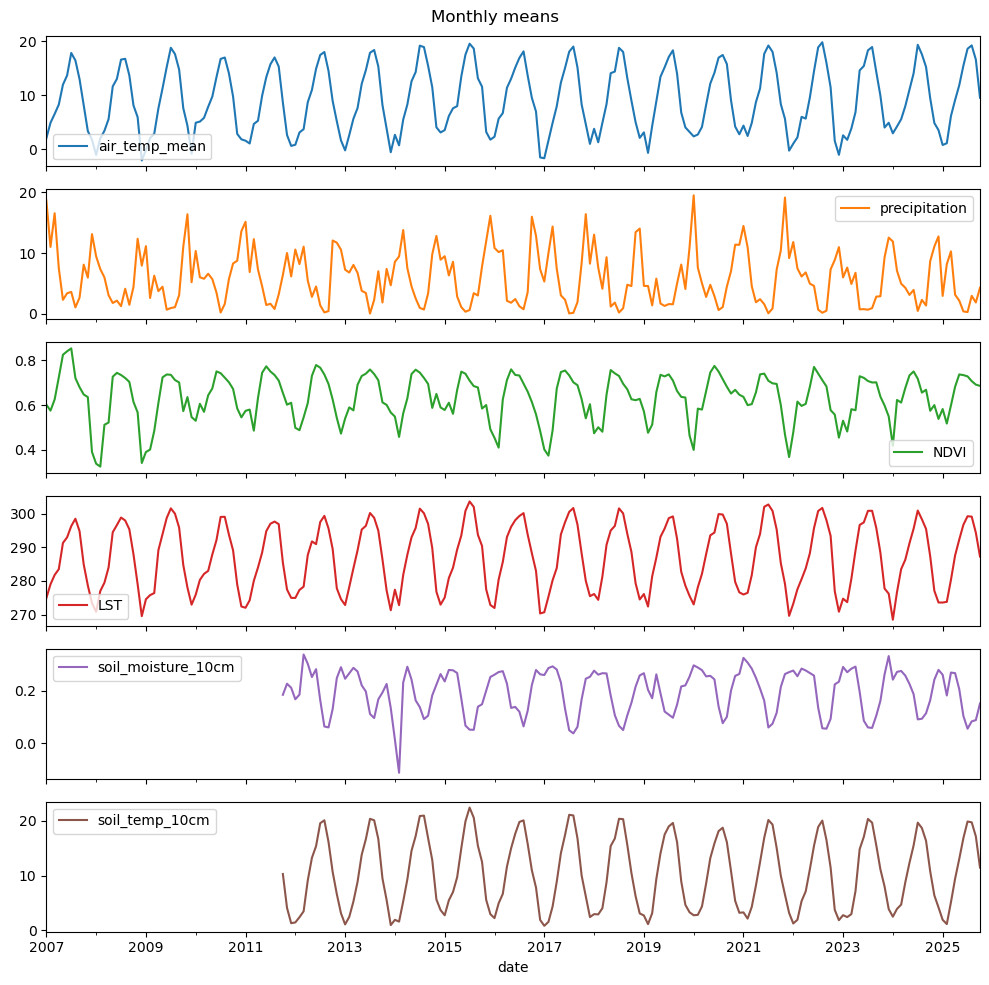

In [101]:
agg_cols = ["air_temp_mean","precipitation","NDVI","LST","soil_moisture_10cm","soil_temp_10cm"]

daily = df.set_index("date").groupby(pd.Grouper(freq="D"))[agg_cols].mean()
weekly = df.set_index("date").groupby(pd.Grouper(freq="W"))[agg_cols].mean()
monthly = df.set_index("date").groupby(pd.Grouper(freq="M"))[agg_cols].mean()

monthly.plot(subplots=True, figsize=(10,10), title="Monthly means"); plt.tight_layout(); plt.show()

### Seasonal Cycle

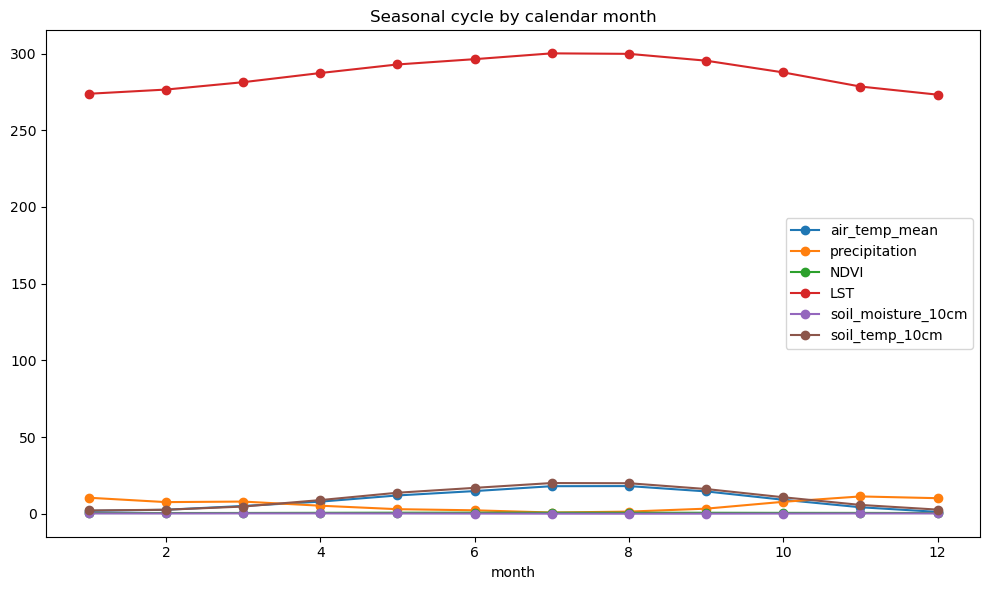

In [102]:
df["month"] = df["date"].dt.month
seasonal = df.groupby("month")[agg_cols].mean()
seasonal.plot(marker="o", figsize=(10,6), title="Seasonal cycle by calendar month"); plt.tight_layout(); plt.show()

---
## Cross-correlation and Lag Analysis

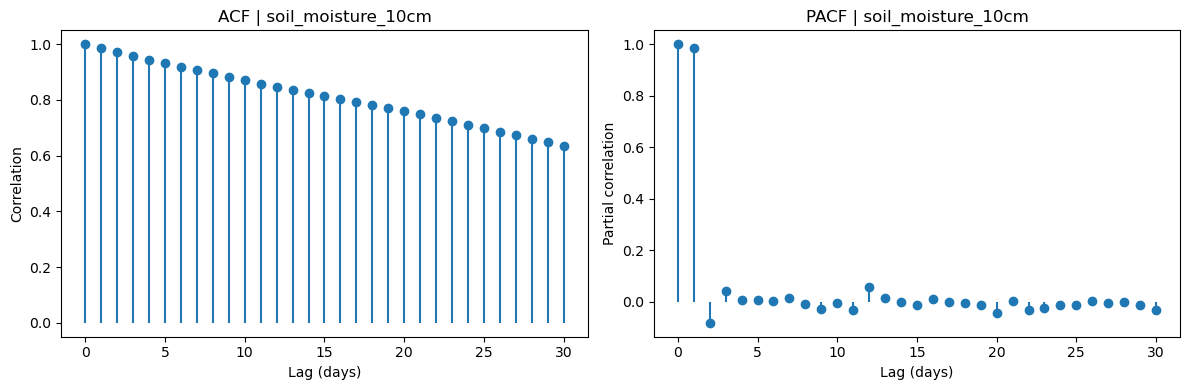

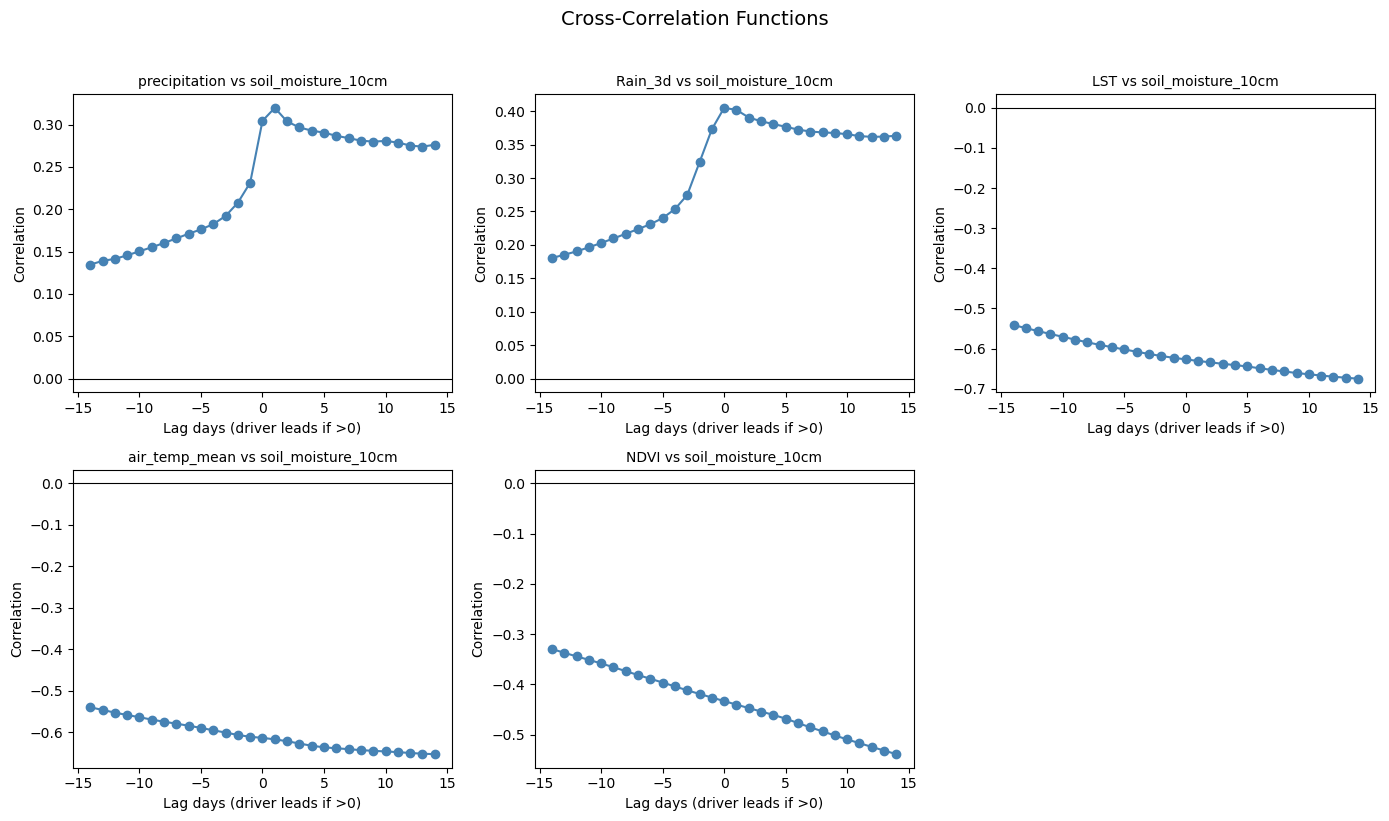

In [104]:
ts = df.set_index("date").sort_index()
series = ts.groupby(pd.Grouper(freq="D"))[
    ["soil_moisture_10cm", "precipitation", "Rain_3d", "NDVI", "LST", "air_temp_mean"]
].mean()

sm_series = series["soil_moisture_10cm"].dropna()
lag_acf = acf(sm_series, nlags=30, missing="drop")
lag_pacf = pacf(sm_series, nlags=30, method="ywm")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].stem(range(len(lag_acf)), lag_acf, basefmt=" ")
axes[0].set_title("ACF | soil_moisture_10cm")
axes[0].set_xlabel("Lag (days)")
axes[0].set_ylabel("Correlation")

axes[1].stem(range(len(lag_pacf)), lag_pacf, basefmt=" ")
axes[1].set_title("PACF | soil_moisture_10cm")
axes[1].set_xlabel("Lag (days)")
axes[1].set_ylabel("Partial correlation")

plt.tight_layout()
plt.show()

def xcorr(x, y, max_lag=14):
    x, y = x.dropna(), y.dropna()
    idx = x.index.intersection(y.index)
    x, y = x.loc[idx], y.loc[idx]
    res = {}
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            r = np.corrcoef(x[-lag:], y[:len(y)+lag])[0, 1]
        elif lag > 0:
            r = np.corrcoef(x[:-lag], y[lag:])[0, 1]
        else:
            r = np.corrcoef(x, y)[0, 1]
        res[lag] = r
    return pd.Series(res)

drivers = ["precipitation", "Rain_3d", "LST", "air_temp_mean", "NDVI"]
n = len(drivers)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, driver in enumerate(drivers):
    if driver in series:
        xr = xcorr(series[driver], series["soil_moisture_10cm"], max_lag=14)
        axes[i].plot(xr.index, xr.values, marker="o", color="steelblue")
        axes[i].axhline(0, color="black", linewidth=0.8)
        axes[i].set_title(f"{driver} vs soil_moisture_10cm", fontsize=10)
        axes[i].set_xlabel("Lag days (driver leads if >0)")
        axes[i].set_ylabel("Correlation")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Cross-Correlation Functions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## Stationary and Stohastic Properties

In [105]:
# to mute the warning for obvious stationarity...
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

def adf_kpss_report(s, name):
    s = s.dropna()
    print(f"=== {name} ===")

    adf_stat, adf_p, *_ = adfuller(s, autolag="AIC")
    print(f"ADF p-value: {adf_p:.4g}  (p<0.05 suggests stationarity)")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=InterpolationWarning)
        kpss_stat, kpss_p, *_ = kpss(s, nlags="auto")

    print(f"KPSS p-value: {kpss_p:.4g} (p<0.05 suggests non-stationarity)")
    print()

for col in ["soil_moisture_10cm","precipitation","NDVI","LST","air_temp_mean"]:
    if col in series:
        adf_kpss_report(series[col], col)

=== soil_moisture_10cm ===
ADF p-value: 1.257e-07  (p<0.05 suggests stationarity)
KPSS p-value: 0.1 (p<0.05 suggests non-stationarity)

=== precipitation ===
ADF p-value: 2.852e-13  (p<0.05 suggests stationarity)
KPSS p-value: 0.1 (p<0.05 suggests non-stationarity)

=== NDVI ===
ADF p-value: 2.07e-09  (p<0.05 suggests stationarity)
KPSS p-value: 0.1 (p<0.05 suggests non-stationarity)

=== LST ===
ADF p-value: 8.753e-15  (p<0.05 suggests stationarity)
KPSS p-value: 0.1 (p<0.05 suggests non-stationarity)

=== air_temp_mean ===
ADF p-value: 7.395e-07  (p<0.05 suggests stationarity)
KPSS p-value: 0.1 (p<0.05 suggests non-stationarity)



In [106]:
sm_diff = series["soil_moisture_10cm"].diff()
adf_kpss_report(sm_diff, "soil_moisture_10cm diff1")

=== soil_moisture_10cm diff1 ===
ADF p-value: 0  (p<0.05 suggests stationarity)
KPSS p-value: 0.1 (p<0.05 suggests non-stationarity)



In [107]:
def granger_summary(data, x, y, maxlag=5):
    gtest = grangercausalitytests(data[[x, y]], maxlag=maxlag)
    res = []
    for lag, val in gtest.items():
        pval = val[0]['ssr_ftest'][1]
        res.append((lag, pval))
    return pd.DataFrame(res, columns=["lag", "p_value"]).set_index("lag")

gdf = series[["soil_moisture_10cm","precipitation"]].dropna()
g_summary = granger_summary(gdf, "soil_moisture_10cm", "precipitation", maxlag=5)
print(g_summary)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=82.8747 , p=0.0000  , df_denom=5131, df_num=1
ssr based chi2 test:   chi2=82.9231 , p=0.0000  , df=1
likelihood ratio test: chi2=82.2606 , p=0.0000  , df=1
parameter F test:         F=82.8747 , p=0.0000  , df_denom=5131, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=70.4712 , p=0.0000  , df_denom=5128, df_num=2
ssr based chi2 test:   chi2=141.0799, p=0.0000  , df=2
likelihood ratio test: chi2=139.1759, p=0.0000  , df=2
parameter F test:         F=70.4712 , p=0.0000  , df_denom=5128, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=45.0052 , p=0.0000  , df_denom=5125, df_num=3
ssr based chi2 test:   chi2=135.2000, p=0.0000  , df=3
likelihood ratio test: chi2=133.4498, p=0.0000  , df=3
parameter F test:         F=45.0052 , p=0.0000  , df_denom=5125, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=33.9172 , p=0.

---
## Feature Engineering Suggestions

In [108]:
# lags
for col, lags in [("soil_moisture_10cm",[1,2,3,7]),
                  ("precipitation",[1,2,3]),
                  ("LST",[1,2,3]),
                  ("NDVI",[1,7,14])]:
    if col in df:
        for L in lags:
            df[f"{col}_lag{L}"] = df.groupby("station_id")[col].shift(L)

# rolling aggregates
roll_cfg = [("precipitation","sum",[3,7,14]),
            ("air_temp_mean","mean",[3,7]),
            ("LST","mean",[3,7]),
            ("soil_moisture_10cm","mean",[3,7])]

for col, func, ws in roll_cfg:
    if col in df:
        for w in ws:
            if func == "sum":
                df[f"{col}_roll{w}_sum"] = df.groupby("station_id")[col].rolling(w).sum().reset_index(level=0, drop=True)
            else:
                df[f"{col}_roll{w}_mean"] = df.groupby("station_id")[col].rolling(w).mean().reset_index(level=0, drop=True)

# thermal indices
if set(["air_temp_max","air_temp_min"]).issubset(df.columns):
    df["diurnal_range"] = df["air_temp_max"] - df["air_temp_min"]

# vegetation dynamics
if "NDVI" in df.columns:
    df["NDVI_diff1"] = df.groupby("station_id")["NDVI"].diff(1)

---
## Predictive Sanity Check

In [109]:
target = "soil_moisture_5cm"
drop_cols = ["date", "source_file", "SM_label", "station_id"]

# keep only numeric non-object columns
Xcols = [c for c in df.columns if c not in drop_cols + [target] and df[c].dtype != object]

tmp = df[[target] + Xcols].dropna()
X = tmp[Xcols]
y = tmp[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print("R2:", r2_score(y_test, pred))
print("RMSE:", mean_squared_error(y_test, pred) ** 0.5)
print("n_features:", len(rf.feature_importances_), "==", len(Xcols))

fi = pd.Series(rf.feature_importances_, index=Xcols).sort_values(ascending=False)
print(fi.head(20))

R2: 0.9732363636565442
RMSE: 0.019558826359290397
n_features: 55 == 55
SM_prev                          0.971461
precipitation                    0.003460
soil_moisture_10cm               0.002471
soil_moisture_10cm_roll7_mean    0.002115
soil_moisture_10cm_roll3_mean    0.002107
soil_moisture_10cm_lag2          0.002005
soil_moisture_10cm_lag3          0.001502
soil_moisture_10cm_lag1          0.001480
precipitation_lag1               0.001236
soil_moisture_20cm               0.001061
soil_moisture_10cm_lag7          0.001053
precipitation_roll3_sum          0.000872
Rain_3d                          0.000788
Rain_sat                         0.000489
precipitation_lag2               0.000449
precipitation_roll14_sum         0.000422
soil_temp_5cm                    0.000417
rh_min                           0.000409
DOY                              0.000373
soil_temp_100cm                  0.000355
dtype: float64


Since that looks a little too good to be true, here's a quick "sanity" check to confirm that

In [110]:
Xcols_noprev = [c for c in Xcols if c != "SM_prev"]
rf.fit(X_train[Xcols_noprev], y_train)
pred_noprev = rf.predict(X_test[Xcols_noprev])
print("R2 (no SM_prev):", r2_score(y_test, pred_noprev))
print("RMSE (no SM_prev):", mean_squared_error(y_test, pred_noprev) ** 0.5)

R2 (no SM_prev): 0.9781621550186491
RMSE (no SM_prev): 0.017667500830155898


Alright yeah, that's crazy good...

In [111]:
print([c for c in X.columns if 'lag' in c or 'roll' in c])

['soil_moisture_10cm_lag1', 'soil_moisture_10cm_lag2', 'soil_moisture_10cm_lag3', 'soil_moisture_10cm_lag7', 'precipitation_lag1', 'precipitation_lag2', 'precipitation_lag3', 'LST_lag1', 'LST_lag2', 'LST_lag3', 'NDVI_lag1', 'NDVI_lag7', 'NDVI_lag14', 'precipitation_roll3_sum', 'precipitation_roll7_sum', 'precipitation_roll14_sum', 'air_temp_mean_roll3_mean', 'air_temp_mean_roll7_mean', 'LST_roll3_mean', 'LST_roll7_mean', 'soil_moisture_10cm_roll3_mean', 'soil_moisture_10cm_roll7_mean']


Ok...that list looks good

In [112]:
sample = df[df["station_id"] == df["station_id"].unique()[0]].sort_values("date")

bad = (sample["LST_lag1"] == sample["LST"].shift(-1)).sum()
print("Leaky LST_lag1 rows:", bad)

Leaky LST_lag1 rows: 6221


This explains it...about 6221 rows in the dataset use future values when constructing lag features...in other words they're peaking ahead of time